In [1]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plot

%matplotlib notebook

In [2]:
import nest
import numpy as np
import numpy.ma as ma #for masked arrays

from lsm.nest import LSM
from lsm.utils import poisson_generator

In [3]:
# set T to number of cores available to speed up simulation
# T = 2
# nest.SetKernelStatus({"local_num_threads": T})

In [4]:
def generate_stimulus_xor(stim_times, gen_burst, n_inputs=2):
    
# generates input states for every input at every time
    inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
    inp_spikes = []
    
# 
    for times in ma.masked_values(inp_states, 0) * stim_times:
        # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
        spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

        # round to simulation precision
        spikes *= 10
        spikes = spikes.round() + 1.0
        spikes = spikes / 10.0

        inp_spikes.append(spikes)

    # astype(int) could be omitted, because False/True has the same semantics
    targets = np.logical_xor(*inp_states).astype(int)

    return inp_spikes, targets


In [5]:
def inject_spikes(inp_spikes, neuron_targets):
    spike_generators = nest.Create("spike_generator", len(inp_spikes))

    for sg, sp in zip(spike_generators, inp_spikes):
        nest.SetStatus([sg], {'spike_times': sp})

    delay = dict(distribution='normal_clipped', mu=10., sigma=20., low=3., high=200.)
    C_inp = 100  # int(N_E / 20)  # number of outgoing input synapses per input neuron

    nest.Connect(spike_generators, neuron_targets,
                 {'rule': 'fixed_outdegree',
                  'outdegree': C_inp},
                 {'model': 'static_synapse',
                  'delay': delay,
                  'weight': {'distribution': 'uniform',
                             'low': 2.5 * 10 * 5.0,
                             'high': 7.5 * 10 * 5.0}
                  })

In [6]:
# Set parameters for the simulation kernel. print progress info during sim, use 11 local threads
nest.SetKernelStatus({'print_time': True, 'local_num_threads': 11})
sim_time = 200000

# stimulus parameters
stim_interval = 300
stim_length = 50
stim_rate = 200  # [1/s]

readout_delay = 10

# set discrete times to inject st
stim_times = np.arange(stim_interval, sim_time - stim_length - readout_delay, stim_interval)
readout_times = stim_times + stim_length + readout_delay

def gen_stimulus_pattern(): return poisson_generator(stim_rate, t_stop=stim_length)

inp_spikes, targets = generate_stimulus_xor(stim_times, gen_burst=gen_stimulus_pattern)

# create liquid state machine object
lsm = LSM(n_exc=1000, n_inh=250, n_rec=500)

# inject input spikes onto input nodes
inject_spikes(inp_spikes, lsm.inp_nodes)



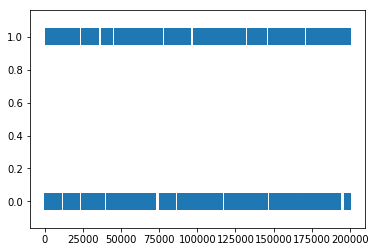

In [7]:
plot.eventplot(inp_spikes,linelengths=0.1)     
plot.show()


In [175]:
inp_spikes


list

In [ ]:
# performance of simulation

# run simulation for some time
nest.Simulate(sim_time)

readout_times = readout_times[5:]
targets = targets[5:]

states = lsm.get_states(readout_times, tau=20)


In [ ]:
# add constant component to states for bias (TODO why?)
states = np.hstack([states, np.ones((np.size(states, 0), 1))])

n_examples = np.size(targets, 0)
n_examples_train = int(n_examples * 0.8)

train_states, test_states = states[:n_examples_train, :], states[n_examples_train:, :]
train_targets, test_targets = targets[:n_examples_train], targets[n_examples_train:]

readout_weights = lsm.compute_readout_weights(train_states, train_targets, reg_fact=5.0)

In [ ]:
def classify(prediction):
        return (prediction >= 0.5).astype(int)

In [ ]:
train_prediction = lsm.compute_prediction(train_states, readout_weights)
train_results = classify(train_prediction)

In [ ]:
test_prediction = lsm.compute_prediction(test_states, readout_weights)
test_results = classify(test_prediction)

In [ ]:
print("simulation time: {}ms".format(sim_time))
print("number of stimuli: {}".format(len(stim_times)))
print("size of each state: {}".format(np.size(states, 1)))

print("---------------------------------------")

def eval_prediction(prediction, targets, label):
    n_fails = sum(abs(prediction - targets))
    n_total = len(targets)
    print("mismatched {} examples: {:d}/{:d} [{:.1f}%]".format(label, n_fails, n_total, n_fails / n_total * 100))

eval_prediction(train_results, train_targets, "training")
eval_prediction(test_results, test_targets, "test")

In [ ]:
# figuring stuff out

In [15]:

n_inputs = 2
gen_burst=gen_stimulus_pattern

# generates input states for every input at every time
inp_states = np.random.randint(2, size=(n_inputs, np.size(stim_times)))
inp_spikes = []

# 
for times in ma.masked_values(inp_states, 0) * stim_times:
    
    # for each input (neuron): generate spikes according to state (=1) and stimulus time-grid
    spikes = np.concatenate([t + gen_burst() for t in times.compressed()])

    # round to simulation precision
    spikes *= 10
    spikes = spikes.round() + 1.0
    spikes = spikes / 10.0

    inp_spikes.append(spikes)

# astype(int) could be omitted, because False/True has the same semantics
targets = np.logical_xor(*inp_states).astype(int)



In [127]:
spikes = np.concatenate([t + gen_burst() for t in times.compressed()])
inp_spikes

[array([  1216.8,   1223.4,   1227.7, ..., 199540.1, 199540.6, 199542.4]),
 array([   303.2,    303.8,    305.9, ..., 199544.9, 199545.8, 199548.5])]

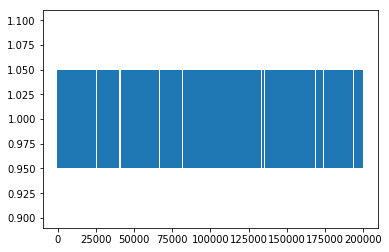

In [99]:
targets.shape
plot.eventplot(spikes,linelengths=0.1)
plot.show()

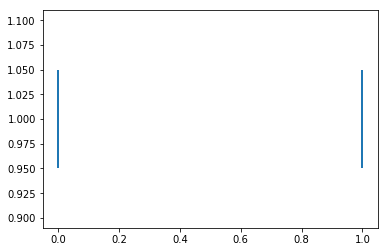

array([0, 1])

In [120]:
plot.eventplot(targets,linelengths=0.1) 
plot.show()
# inp_states = inp_states[:,1:10]
# np.logical_xor(*inp_states).astype(int)


In [111]:
# ax1 = sns.scatterplot(x=inp_states[0], y=inp_states[1],hue = targets)
# times.compressed()

#

inp_spikes[1].shape

# 

TypeError: type() takes 1 or 3 arguments

In [17]:
inp_spikes.index
# ax1 = sns.scatterplot(x = inp_spikes.index, y = inp_spikes[1])

<function list.index(value, start=0, stop=9223372036854775807, /)>

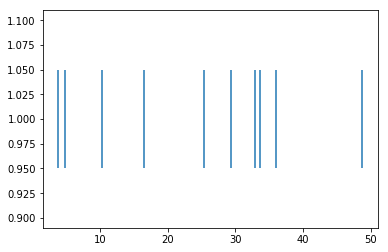

In [18]:

plot.eventplot(gen_burst(),linelengths=0.1)     
plot.show()

In [45]:
# importing spike trains to 

import pandas as pd
data4_090=pd.read_csv('/Users/calebparikh/Documents/dissertation/Moving bars/PVC-11/stimuli_gratings/4_090.csv', sep=',',header=None)


data4_090.values
data4_090.head()
data4_090.shape

data4_000=pd.read_csv('/Users/calebparikh/Documents/dissertation/Moving bars/PVC-11/stimuli_gratings/4_000.csv', sep=',',header=None)
data4_180=pd.read_csv('/Users/calebparikh/Documents/dissertation/Moving bars/PVC-11/stimuli_gratings/4_180.csv', sep=',',header=None)
data4_270=pd.read_csv('/Users/calebparikh/Documents/dissertation/Moving bars/PVC-11/stimuli_gratings/4_270.csv', sep=',',header=None)




In [37]:
# function that generates spike patterns using poisson distribution based on spike rate

def gen_stimulus_variable_pattern(rate): 
    return poisson_generator(rate, t_stop=stim_length)

# plot.eventplot(gen_stimulus_variable_pattern(5),linelengths=0.1)     
# plot.show()
# plot.eventplot(gen_stimulus_variable_pattern(50),linelengths=0.1)     
# plot.show()
# plot.eventplot(gen_stimulus_variable_pattern(5000),linelengths=0.1)     
# plot.show()

In [40]:
# generate spike trains for all neurons with movie in a direction 
# function takes a dataframe with neuronal patterns for a certain direction and resturnse list of arrays for train for each neuron

def directedSpikes(df):
    temp = np.array([])
    trains = []

    for j in range(len(df)):
        neuron = df.iloc[j, :].values
        for i in range(len(neuron)):
            temp = np.append(temp,gen_stimulus_variable_pattern(neuron[i]))
        trains.append(temp)
    return trains
        
        
        
#     
# 

In [46]:
train = directedSpikes(df)

train1 = directedSpikes(data4_000)
train2 = directedSpikes(data4_090)
train3 = directedSpikes(data4_180)
train4 = directedSpikes(data4_270)

In [58]:
trainCumulative = []
for i in range(len(train1)):
    trainCumulative.append(np.concatenate((train1[i], train2[i],train3[i],train4[i]), axis=0))
    
    

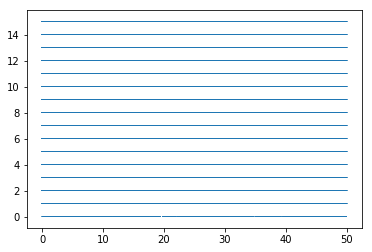

(658,)

In [72]:
# i = 1
# trainCumulative = []
# trainCumulative.append(np.concatenate((train1[i], train2[i],train3[i],train4[i]), axis=0))
len(trainCumulative)
plot.eventplot(trainCumulative,linelengths=0.1)     
plot.show()
train1[1].shape



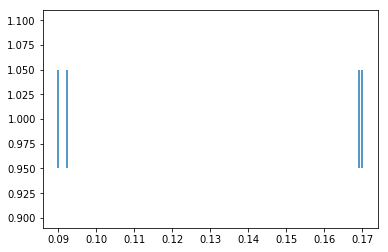

AttributeError: 'list' object has no attribute 'shape'

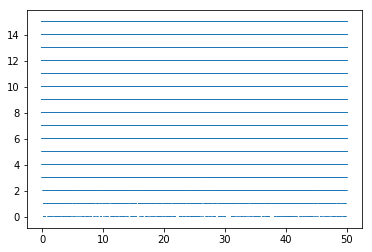

In [42]:
plot.eventplot(trains,linelengths=0.1)     
plot.show()

In [159]:
# print(train)
range(len(df))
train.shape
temp = np.append(temp,gen_stimulus_variable_pattern(neuron[2]))

temp.shape
temp

array([ 7.68975543, 11.74845156, 24.79537889, 25.90181267, 31.93210292,
       37.20277634, 41.59909695, 41.9189001 ,  1.7751941 ,  2.3087038 ,
        3.13374795, 27.8669721 , 35.64358017, 48.32251521,  4.00298678,
        6.32282568, 11.74618296, 15.2022439 , 19.80666675, 21.68044226,
       32.39376589, 36.6695276 , 45.18527069,  2.25977154, 12.03267654,
       16.12871032, 23.74545261, 25.36210865, 25.71761606, 29.53895374,
       45.73889668, 46.61668795, 49.58667147,  5.06434851,  5.37113203,
       15.35369805, 23.71552885, 25.11663352, 27.8476312 , 28.50827739,
       29.55083137, 34.98734046, 38.64752877, 41.874158  ])

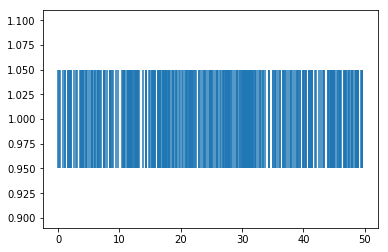

In [96]:
plot.eventplot(train,linelengths=0.1)     
plot.show()